<a href="https://colab.research.google.com/github/annvix/Accents_LSTM-/blob/master/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Клонирование проекта с GitHub
Подключение библиотек

In [2]:
!git clone https://github.com/annvix/Accents_LSTM-.git

Cloning into 'Accents_LSTM-'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 156 (delta 26), reused 0 (delta 0), pack-reused 95
Receiving objects: 100% (156/156), 22.97 MiB | 16.87 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [3]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

from keras.layers import *
from keras.models import *
from keras.optimizers import *
from tensorflow.keras.preprocessing import sequence

Using TensorFlow backend.


# Загрузка и предобработка данных

Добавляем алфавит для кодирования букв

In [4]:
alphabet =   {'а' : 1, 'б' : 2, 'в' : 3, 'г' : 4, 'д' : 5, 'е' : 6, 'ё' : 7, 'ж' : 8, 'з' : 9,
             'и' : 10, 'й' : 11, 'к' : 12, 'л' : 13, 'м' : 14, 'н' : 15, 'о' : 16, 'п' : 17, 'р' : 18,
             'с' : 19, 'т' : 20, 'у' : 21, 'ф' : 22, 'х' : 23, 'ц' : 24, 'ч' : 25, 'ш' : 26, 'щ' : 27,
             'ъ' : 28, 'ы' : 29, 'ь' : 30, 'э' : 31, 'ю' : 32, 'я' : 33}

N = 10 #Количество слов для вывода

In [5]:
with open('Accents_LSTM-/Data.csv', 'r') as f:
    all_accents = f.readlines()
data_len = len(all_accents)

print('Всего слов:', data_len)
max_len = len(max(all_accents, key=len)) //2 - 1
print('Максимальная длина слова:', max_len)
print('Слово:', max(all_accents, key=len))
number_of_classes = 32#max_len + 1

Всего слов: 1678878
Максимальная длина слова: 29
Слово: административнодисциплинарный,административнодисципл'инарный



Группировка слов по первым буквам

In [6]:
word_groups = []
group  = []
group.append(all_accents[0])

for i in range(1, data_len):
    if group[0][:4] == all_accents[i][:4]:
        group.append(all_accents[i])
    else:
        word_groups.append(group)
        group  = []
        group.append(all_accents[i])
print('Количество групп: ', len(word_groups))
random.shuffle(word_groups)

Количество групп:  42078


In [7]:
print('Группы слов:')
for i in range (N):
  print(word_groups[i])

Группы слов:
["хальбхерр,хальбх'ерр\n", "хальвдане,х'альвдане\n", "хальдоур,х'альдоур\n", "хальдун,хальд'ун\n", "халькантит,халькант'ит\n", "халькогениды,халькоген'иды\n", "халькогены,хальког'ены\n", "халькозин,халькоз'ин\n", "халькозина,халькоз'ина\n", "халькопирит,халькопир'ит\n", "халькопирита,халькопир'ита\n", "халькопиритам,халькопир'итам\n", "халькопиритами,халькопир'итами\n", "халькопиритах,халькопир'итах\n", "халькопирите,халькопир'ите\n", "халькопиритов,халькопир'итов\n", "халькопиритом,халькопир'итом\n", "халькопириту,халькопир'иту\n", "халькопириты,халькопир'иты\n", "халькоцит,халькоц'ит\n", "хальмг,х'альмг\n", "хальмоши,х'альмоши\n", "хальмстад,х'альмстад\n", "хальмстада,х'альмстада\n", "хальмстадам,х'альмстадам\n", "хальмстадами,х'альмстадами\n", "хальмстадах,х'альмстадах\n", "хальмстаде,х'альмстаде\n", "хальмстадец,хальмст'адец\n", "хальмстадов,х'альмстадов\n", "хальмстадом,х'альмстадом\n", "хальмстаду,х'альмстаду\n", "хальмстады,х'альмстады\n", "хальтер,хальт'ер\n", "хал

Разделим данные на тренировочные, валидационные и тестовые

In [8]:
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

def train_test_val_words(words):
    return (words[:int(len(words)*train_frac)], 
words[int(len(words)*train_frac) : (int(len(words)*train_frac) + int(len(words)*val_frac))], 
words[(int(len(words)*train_frac) + int(len(words)*val_frac)):])
    

for_train, for_val, for_test = train_test_val_words(word_groups)

In [9]:
def words_to_num(my_words):
  words, accents = [], []
  for i in range (len(my_words)):
      str = my_words[i].replace('\n', '').split(',')
      words.append(str[0])
      accents.append(str[1])

  words_int = np.zeros((len(my_words), number_of_classes), dtype=int)
  accents_int = np.zeros((len(my_words),number_of_classes), dtype=int)
  
  for i in range(len(words)):
    for j in range(len(words[i])):
        words_int[i][j]= alphabet[words[i][j]]
        
    acc = accents[i].find("'")
    if (acc != -1):
        accents_int[i][acc] = 1
        if accents[i][acc + 1:].find("'") != -1:
          print('В слове два ударения:', accents[i])
    else:
        accents_int[i][number_of_classes - 1] = 1
        print('Нет ударения: ', words[i])
  return words_int, accents_int

In [10]:
train_x, train_y= [], []
for i in range(len(for_train)):
  w, a = words_to_num(for_train[i])
  for j in range(len(for_train[i])):
    train_x.append(w[j])
    train_y.append(a[j])
  
val_x, val_y= [], []
for i in range(len(for_val)):
  w, a = words_to_num(for_val[i])
  for j in range(len(for_val[i])):
    val_x.append(w[j])
    val_y.append(a[j])

test_x, test_y= [], []
for i in range(len(for_test)):
  w, a = words_to_num(for_test[i])
  for j in range(len(for_test[i])):
    test_x.append(w[j])
    test_y.append(a[j])


Нет ударения:  тсс
Нет ударения:  с
Нет ударения:  хм
Нет ударения:  гм
Нет ударения:  брр
В слове два ударения: обагр'я'ясь
Нет ударения:  б
Нет ударения:  ль
Нет ударения:  в
Нет ударения:  кш
Нет ударения:  к
Нет ударения:  мм
Нет ударения:  ж


In [11]:
test_x = np.array(test_x) 
train_x = np.array(train_x) 
val_x = np.array(val_x) 

test_y = np.array(test_y) 
train_y = np.array(train_y) 
val_y = np.array(val_y) 

In [12]:
print("\t\t\t Размеры:")
print("Train set: \t\t{}".format(test_x.shape), 
      "\nValidation set: \t{}".format(train_x.shape),
      "\nTest set: \t\t{}".format(val_x.shape))

			 Размеры:
Train set: 		(159498, 32) 
Validation set: 	(1311635, 32) 
Test set: 		(207744, 32)


# Моделирование нейронной сети

# LSTM

In [ ]:
# max_features = len(alphabet) + 1
# max_features

In [ ]:
# # LSTM model
# model = Sequential()
# model.add(Embedding(input_dim = max_features, output_dim = number_of_classes, input_length=number_of_classes))
# model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(256, activation='relu')) #256
# model.add(Dense(256, activation='relu'))
# model.add(Dense(number_of_classes, activation='softmax'))

# model.compile(loss='categorical_crossentropy')

In [ ]:
# #LSTM
# history = model.fit(train_x, train_y,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_data=(val_x, val_y))

# U-net

In [ ]:
# def unet(input_size = (number_of_classes, 1)):

#     inputs = Input(input_size)

#     conv1 = Conv1D(64, 2, activation = 'relu')(inputs)
#     conv1 = Conv1D(64, 2, activation = 'relu')(conv1)
#     pool1 = MaxPooling1D(pool_size=2)(conv1)

#     conv2 = Conv1D(128, 2, activation = 'relu', kernel_initializer = 'he_normal')(pool1)
#     conv2 = Conv1D(128, 2, activation = 'relu', kernel_initializer = 'he_normal')(conv2)
#     drop2 = Dropout(0.5)(conv2)
#     pool2 = MaxPooling1D(pool_size=2)(conv2)

#     conv3 = Conv1D(256, 2, activation = 'relu', kernel_initializer = 'he_normal')(pool2)
#     conv3 = Conv1D(256, 2, activation = 'relu', kernel_initializer = 'he_normal')(conv3)
#     drop3 = Dropout(0.5)(conv2)

#     up4 = Conv1D(128, 2, activation = 'relu', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(drop3))
#     merge4 = concatenate([drop2,up4], axis = 1)
#     conv4 = Conv1D(128, 2, activation = 'relu', kernel_initializer = 'he_normal')(merge4)
#     conv4 = Conv1D(128, 2, activation = 'relu', kernel_initializer = 'he_normal')(conv4)

#     up5 = Conv1D(64, 2, activation = 'relu', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv4))
#     merge5 = concatenate([conv1,up5], axis = 1)
#     conv5 = Conv1D(64, 2, activation = 'relu', kernel_initializer = 'he_normal')(merge5)
#     conv5 = Conv1D(64, 2, activation = 'relu', kernel_initializer = 'he_normal')(conv5)
#     conv5 = Conv1D(2, 2, activation = 'relu', kernel_initializer = 'he_normal')(conv5)
#     conv6 = Conv1D(30, 90, activation = 'softmax')(conv5)
    
#     model = Model(input = inputs, output = conv6)

#     model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
#     print(model.summary())

#     return model

In [ ]:
# model = unet()

In [ ]:
# batch_size = 256
# epochs = 10

# X_train = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
# Y_train = np.reshape(train_y, (train_y.shape[0], 1, train_y.shape[1]))

# X_val =  np.reshape(val_x, (val_x.shape[0], 1, val_x.shape[1]))
# Y_val =  np.reshape(val_y, (val_y.shape[0], 1, val_y.shape[1]))

# history = model.fit(X_train, Y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_data=(X_val, Y_val))

# resU-net

In [13]:
max_features = len(alphabet) + 1

In [23]:
def res_unet(filter_root, depth, n_class=number_of_classes, input_size = (number_of_classes, ), activation='relu', 
             batch_norm=True, final_activation='softmax', embed = number_of_classes):
    """
    Build UNet model with ResBlock.
    Args:
        filter_root (int): Number of filters to start with in first convolution.
        depth (int): How deep to go in UNet i.e. how many down and up sampling you want to do in the model. 
                    Filter root and image size should be multiple of 2^depth.
        n_class (int, optional): How many classes in the output layer. Defaults to 2.
        input_size (tuple, optional): Input image size. Defaults to (256, 256, 1).
        activation (str, optional): activation to use in each convolution. Defaults to 'relu'.
        batch_norm (bool, optional): To use Batch normaliztion or not. Defaults to True.
        final_activation (str, optional): activation for output layer. Defaults to 'softmax'.
    Returns:
        obj: keras model object
    """
    #input_shape = (input_size, 1)

    inputs = Input(input_size)
    x = inputs

    # batch_size = 256
    # #em = Embedding(max_features, embed, output_dim = number_of_classes, batch_input_shape=(batch_size, number_of_classes))(x)
    em = Embedding(input_dim = max_features, output_dim = number_of_classes)(x)
    x = em

    # Dictionary for long connections
    long_connection_store = {}

    #Conv = Conv1D
    # MaxPooling = MaxPooling1D
    # UpSampling = UpSampling1D

    # Down sampling
    for i in range(depth):
        out_channel = 2**i * filter_root
 
        # Residual/Skip connection
        res = Conv1D(out_channel, kernel_size=1, padding='same', use_bias=False)(x)
        # First Conv Block with Conv, BN and activation
        conv1 = Conv1D(out_channel, kernel_size=3, padding='same')(x)
        if batch_norm:
            conv1 = BatchNormalization()(conv1)
        act1 = Activation(activation)(conv1)
        
        # Second Conv block with Conv and BN only
        conv2 = Conv1D(out_channel, kernel_size=3, padding='same')(act1)
        conv2 = Dropout(0.3)(conv2)

        if batch_norm:
            conv2 = BatchNormalization()(conv2)

        resconnection = Add()([res, conv2])

        act2 = Activation(activation)(resconnection)

        # Max pooling
        if i < depth - 1:
            long_connection_store[str(i)] = act2
            x = MaxPooling1D(padding='same')(act2)
        else:
            x = act2

    # Upsampling
    for i in range(depth - 2, -1, -1):
        out_channel = 2**(i) * filter_root

        # long connection from down sampling path.
        long_connection = long_connection_store[str(i)]
 
        up1 = UpSampling1D()(x)

        up_conv1 = Conv1D(out_channel, 2, padding='same', activation='relu')(up1)

        #  Concatenate.
        up_conc = Concatenate(axis=-1)([up_conv1, long_connection])

        #  Convolutions
        up_conv2 = Conv1D(out_channel, 3, padding='same')(up_conc)
        if batch_norm:
            up_conv2 = BatchNormalization()(up_conv2)
        up_act1 = Activation(activation)(up_conv2)

        up_conv2 = Conv1D(out_channel, 3, padding='same')(up_act1)
        if batch_norm:
            up_conv2 = BatchNormalization()(up_conv2)

        # Residual/Skip connection
        res = Conv1D(out_channel, kernel_size=1, padding='same', use_bias=False)(up_conc)

        resconnection = Add()([res, up_conv2])

        x = Activation(activation)(resconnection)

    # Final convolution
    output = Conv1D(1, 3, padding='same')(x)
    output1 = Flatten()(output)   
    output2 = Dense(number_of_classes, activation='softmax')(output1)

    model = Model(inputs, outputs=output2)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    print(model.summary())

    return model

In [24]:
model = res_unet(64, 3, number_of_classes, input_size=(number_of_classes,))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 32, 32)       1088        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 32, 64)       6208        embedding_2[0][0]                
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 32, 64)       256         conv1d_20[0][0]                  
____________________________________________________________________________________________

In [25]:
batch_size = 256*4
epochs = 4

In [1]:
history = model.fit(train_x, train_y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_x, val_y))

NameError: ignored

Построим графики для точности и функции стоимости относительно эпох

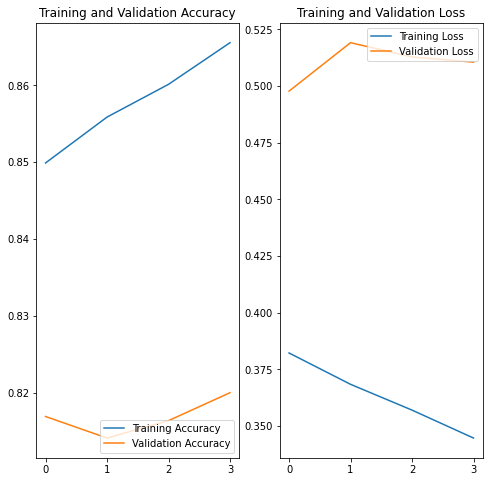

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Сохраним предобученную сеть

In [ ]:
model.save('Accents_LSTM-/resUnet_model.h5')
files.download('Accents_LSTM-/resUnet_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Сохраним датасет на компьютер

In [ ]:
files.download('Accents_LSTM-/Data.csv')

# Тесты на обученной модели

In [ ]:
# model = load_model('Accents_LSTM-/resUnet_model.h5')

In [ ]:
# model.compile(optimizer='adam',
#                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy'),
#                   metrics=['accuracy'])

Предскажем позицию ударения для тестовых данных

In [ ]:
X_test = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
Y_test = np.reshape(test_y, (test_y.shape[0], 1, test_y.shape[1]))

acc_pred = model.predict(X_test)

test_accur = 0
for i in range(len(acc_pred)):
    if acc_pred[i].argmax() == Y_test[i].argmax():
        test_accur = test_accur + 1
test_accur = test_accur/len(acc_pred)

In [ ]:
print('Точность на тестовой выборке: ',test_accur)

Точность на тестовой выборке:  0.6946755454326154


Метод для возвращения ключа по значению

In [ ]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

Визуализация предсказанных ударений и их сравнение с ответами

In [ ]:
for i in range(N):
    slovo = ''
    k = i * 500
    for j in range(len(X_test[k][0])):

        if X_test[k][0][j] != 0:
            slovo = slovo + get_key(alphabet, X_test[k][0][j])
        else:
            break

    template = slovo[:Y_test[k][0].argmax() + 1] + '\'' + slovo[Y_test[k][0].argmax() + 1:]
    nn_sample = slovo[:acc_pred[k][0].argmax() + 1] + '\'' + slovo[acc_pred[k].argmax() + 1:]
    
    if (acc_pred[k].argmax() != Y_test[k].argmax()):
      print('Эталон   : ' , template)
      print('Ошибка!  : ' , nn_sample)
    else:
      print('Результат: ' , nn_sample)
    print()

Эталон   :  чанпи'н
Ошибка!  :  ча'нпин

Эталон   :  бескозы'ркою
Ошибка!  :  беск'озыркою

Результат:  дави'вших

Результат:  упражня'емого

Результат:  бо'ро

Результат:  боронова'ния

Результат:  франкофи'льскими

Результат:  дю'жины

Эталон   :  хрестомати'йнейшие
Ошибка!  :  хрестоматийн'ейшие

Результат:  федо'сьевка

